# 07 - Deep Learning

## 04 - CNN Object Detection

![](https://images.unsplash.com/photo-1469854523086-cc02fe5d8800?ixlib=rb-1.2.1&ixid=eyJhcHBfaWQiOjEyMDd9&auto=format&fit=crop&w=1008&q=80)
Picture by [Dino Reichmuth](https://unsplash.com/photos/A5rCN8626Ck)

___

Up to now, we only know how to use CNN to make image classification: whether our image contains a dog or a cat. What if we want to know **where** is the cat?

# I. Object Detection

For this section, let's say we want to detect a car in an image, for example the following:

![](images/car_alone.png)

## I.1. Bounding Box

A way to get the position of an object into an image is to compute a **bounding box** around it. This is the most common way to get the position of an object into an image.

How to define a bounding box? With 4 values:
* The center $b_x$ and $b_y$ of the bounding box
* The height $b_h$ and width $b_w$ of the bounding box

In our example picture with a car, the center of the bounding box would be (480, 400), for an height of 200 and a width of 300 pixels. 

That would give that on our image with such a bounding box:

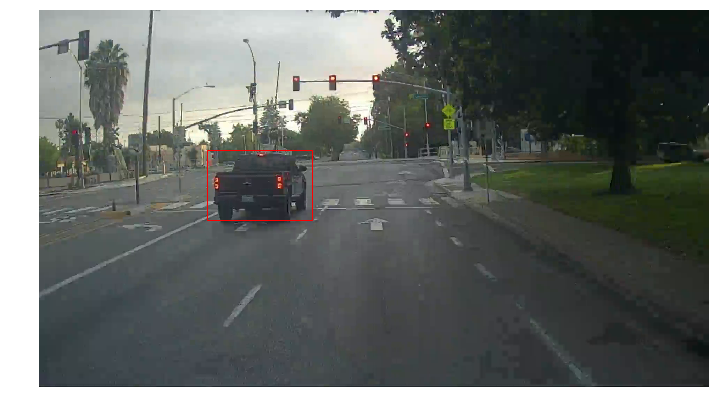

In [3]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches

# Define the figure
fig, ax = plt.subplots(1, figsize=(12,8))
# Read the image
img = plt.imread('images/car_alone.png')
# Create a rectangle patch
rect = patches.Rectangle((480,400),300,200,linewidth=1,edgecolor='r',facecolor='none')
# Add the patch to the figure
ax.add_patch(rect)
# Display the image
plt.axis('off')
plt.imshow(img)

How would you compute such a target with a neural network?

One way of doing so is having the following target vector:
$$
\begin{equation*}
y = \begin{bmatrix}
p \\
b_x \\
b_y \\
b_w\\
b_h
\end{bmatrix}
\end{equation*}
$$

Where $p=1$ when there is the object in the image ($p=0$ otherwise), and $(b_x, b_y, b_w, b_h)$ are the characteristics of the bounding box. This target is what your neural network will have to learn.

What about the case when you have an image without object? What values will take $(b_x, b_y, b_w, b_h)$ according to you?

How to deal with more than one car in the image?

## I.2. Sliding Window

The first idea to get such a bounding box is to have trained a CNN on really sharp images of cars and empty backgrounds like the following:

<img src="images/car_label_image.jpg" width="200">

Then you would apply this binary classification on small areas of an image to find where there is a car:
![](images/sliding_window_bigSize.gif)

Bingo! In one of our subimages, there is the car, so we would finally end up with having a car in our image in the following location:
![](images/car_box_5.jpg)

Good, but not very accurate... The box is way too big, and we could not guess that before watching at the picture! The only to fit every case is to do that with several box sizes, like the following:
![](images/sliding_window_keepTrue_twoBoxSizes.gif)

So we finally end up with the following output:
![](images/car_box_with_boxes.jpg)

Far from being perfect, but we will see in the next section how to keep only the best box. There is another drawback to this method: this is computationally intensive! We have to loop over all the boxes in the image, for all the box sizes we want, and predict a CNN output for each iteration!

Let's see how to improve that!

## I.3. Application to digits

Let's do this to find digits in an image!

First we rebuild the LeNet-5 network, and load the weights:

In [1]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import MaxPooling2D, Conv2D, Flatten, Dense


def lenet5():
    
    model = Sequential()

    # Layer C1
    model.add(Conv2D(filters=6, kernel_size=(3, 3), activation='relu', input_shape=(28,28,1)))
    # Layer S2
    model.add(MaxPooling2D(pool_size=(2, 2)))
    # Layer C3
    model.add(Conv2D(filters=16, kernel_size=(3, 3), activation='relu'))
    # Layer S4
    model.add(MaxPooling2D(pool_size=(2, 2)))
    # Before going into layer C5, we flatten our units
    model.add(Flatten())
    # Layer C5
    model.add(Dense(units=120, activation='relu'))
    # Layer F6
    model.add(Dense(units=84, activation='relu'))
    # Output layer
    model.add(Dense(units=10, activation = 'softmax'))
    
    return model

Here we instantiate the model and load pretrained weights:

In [3]:
model = lenet5()

model.load_weights('lenet5_weights.h5')

Then we will try to find digits on the following image:
![](images/digits.png)

(84, 84, 1)


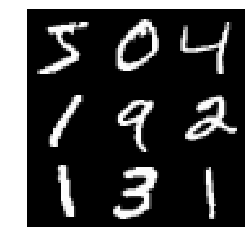

In [6]:
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import matplotlib.pyplot as plt

# Load and display the image
img = img_to_array(load_img('images/digits.png', grayscale=True))
print(img.shape)
plt.imshow(img.reshape(84, 84), cmap='gray')
plt.axis('off')
plt.show()

We will now use a sliding window to find the numbers:

In [7]:
import numpy as np
output = []
for i in range(img.shape[0]//28):
    for j in range(img.shape[1]//28):

        tmp = img[i*28:(i+1)*28, j*28:(j+1)*28]
        
        prediction = np.argmax(model.predict(tmp.reshape(1, 28, 28, 1)))
        output.append(prediction)
        
print(output)

[5, 0, 4, 1, 9, 2, 1, 3, 1]


Finally, we can print them on top of the image to check if it's true:

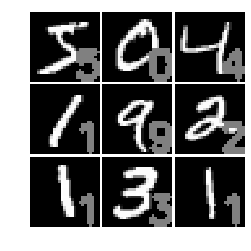

In [9]:
import cv2

for i in range(img.shape[0]//28):
    for j in range(img.shape[1]//28):

        cv2.rectangle(img, (i*28, j*28), ((i+1)*28, (j+1)*28), (255, 0, 0), 1)
        cv2.putText(img, str(output[i*3+j]), ((j)*28+18, (i+1)*28-2), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (128, 0, 0), 2)

plt.imshow(img.reshape(84, 84), cmap='gray')
plt.axis('off')
plt.show()

## I.4. Convolutional Sliding Window (Optional)

Actually, that sliding window, doesn't it look familiar to you? Isn't it just a special case of a convolution?

If we choose a stride with the heigth and width of the bounding box, we can directly compute this sliding window as a convolution! Thus we will take advantage of the convolution optimization computation! Eureka!

![](images/conv_sliding_window.png)

## I.5. Multiple object detection

To summarize, when doing object detection, you end up with a list of prediction arrays $\hat{y}$ of the form:
$$
\begin{equation*}
\hat{y} = \begin{bmatrix}
p \\
b_x \\
b_y \\
b_w\\
b_h
\end{bmatrix}
\end{equation*}
$$

Where:
* p is the probability that there is an object in the image
* $(b_x, b_y, b_w, b_h)$ are the bounding box characteristics

**What if we want to detect several objects?** For example a car, a bike, a truck... We would do exactly the same, but with an output vector like this:
$$
\begin{equation*}
\hat{y} = \begin{bmatrix}
p_c \\
c_{car} \\
c_{bike} \\
c_{truck} \\
b_x \\
b_y \\
b_w\\
b_h
\end{bmatrix}
\end{equation*}
$$

Where now:
* $p_c$ is the probability that there is an object in the image
* $c_{car}$, $c_{bike}$, $c_{truck}$ are the probability that the object is a car, a bike or a truck respectively

# II. Removing the duplicated boxes

As you have seen, even if with this method we have an object detection, this is not working perfectly: we may have more than one box per object. This might bring several problems:
- If we have more than one box for a given object, which one to keep?
- If we remove boxes, how to be sure we do not remove one from another, close, object?

## II.1. Intersection over Union (IoU)

Intersection over union is a metrics that allows you to compute how much two boxes overlap. This will help us decide whether a box should be removed or not.

IoU is defined as the intersection of two boxes over the union of the same boxes:
![](images/iou.png)

Quite intuitively, the IoU could be seen as a score ranging from 0 to 1:
- IoU=1: two boxes that perfectly overlap
- IoU=0: two boxes that do not overlap at all

You will have to compute the IoU by yourself in the exercices.

## II.2. Non-max Suppression

Now that you can compute the IoU, the next step is to perform the non-max suppression algorithm. This is an algorithm that is supposed to remove all the boxes related to a same object, so that any object has only one box.

The algorithm is the following:

<ol>
<li> Discard all boxes with a prediction probability $p$ below a *probability threshold* </li>
<li> Pick the highest prediction probability $p$ and discard all boxes with a IoU above an *IoU threshold* </li>
<li> Repeat step 2 with the remaining boxes until there is no left box </li>
</ol>

It would give this kind of results:

![](images/nms.jpg)

As you can see, this algorithm can be implemented with a `while` loop and has 2 hyperparameters :
- the probability threshold
- the IoU threshold

You will have to code it in today's exercises.

# III. YOLO Algorithm

## III.1. You Only Look Once

The YOLO algorithm reuses all you learnt today and goes even furter. You might have noticed that our bounding box was never really accurate, because we used predefined box sizes. What if we have a long object like a bus? Or a very thin and tall object like a pedestrian? Our boxes won't work well.

YOLO algorithm divides the image into, say, 2x3 parts, like in the following image:

![](images/YOLO.png)


Now for each cell, our neural network will no longer make sliding window, but **both classification and regression** using the following target:
$$
\begin{equation*}
y = \begin{bmatrix}
p \\
b_x \\
b_y \\
b_w\\
b_h
\end{bmatrix}
\end{equation*}
$$

Now, the box dimensions will be learnt too, and will thus be much more accurate!

Up to today, our labels were usually an integer for classification or a real for regression. 
The drawback is that now, our labels will be much more complicated. 

Now labels will be an array like the one above for each cell of the grid. So that in our example, our labels will have the shape `[5, 3, 2]` where:
- 5 = 4 (boxes coordinates) + 1 (classification probability): can be much higher for multiobject detection
- 3 = number of vertical cells
- 2 = number of horizontal cells

Of course, for real problems, the image is not divided into 3x2, but into a much finer grid, for example 19x19.

## III.2. Multiple Objects & Anchor Boxes

Finally, what is we have multiple objects within one cell of the grid? The YOLO algorithm can not support this case in the way we described it.

Actually it can, because YOLO also uses what are called **anchor boxes**. Having multiple anchor boxes allow the algorithm to detect several objects per grid cell, and to specialize depending on the shape of the object.

Usually there are several anchor boxes with different shapes, like in the following image:
![](images/anchor_boxes.png)


Each anchor box would have an associated label, so that finally our target would be the following:
$$
\begin{equation*}
y = \begin{bmatrix}
p \\
b_x \\
b_y \\
b_w\\
b_h \\
p \\
b_x \\
b_y \\
b_w\\
b_h
\end{bmatrix}
\end{equation*}
$$

# IV. Object Detection with TensorFlow

## IV.1. TensorFlow Object Detection API Introduction

TensorFlow provides an object detection API that allows to use already trained neural networks. Those neural networks are trained on **hundreds of thousands images**, and are thus much more accurate than what you could do by yourself!

All the code of this API is available on GitHub [here](https://github.com/tensorflow/models/tree/master/research/object_detection). So that all you need is free to use!

## IV.2. Models

Several trained models are free and available already, with information about their performance and processing time they need [here](https://github.com/tensorflow/models/blob/master/research/object_detection/g3doc/detection_model_zoo.md). 

They are based on YOLO algorithm, or closely related algorithms that have the same behaviour. So that the outputs will follow the same rules.

## IV.3. Outputs

The output when using the API is a dictionary, having the following structure:
```Python
Output = {'num_detections': 1,
          'detection_boxes': [y_min, x_min, y_max, x_max],
          'detection_scores':[0.6],
          'detection_classes':[1]}
```

Where:
- the `'detection_scores'` are between 0 and 1, 
- the `x` and `y` of the `'detection_boxes'` are between 0 and 1
- the `'detection_classes'` are between 1 and 90

More specifically, the entrie `'detection_boxes'`, `'detection_scores'` and `'detection_classes'` will always have the same length, no matter the number of detections. This is related to the way the algorithm works.

You task on this output is then to apply non max suppression algorithm.